# **MIE1513: Final Project**
### Submission date: April 20, 2020 at 23:59pm

-------------

## Academic Integrity Declaration:
In submitting this assessment, I confirm that my conduct during this project adheres to the Code of Behaviour on Academic Matters. I confirm that I have not acted in such a way that would constitute cheating, misrepresentation, or unfairness, including but not limited to, using unauthorized aids and assistance, impersonating another person, and committing plagiarism. I pledge upon my honour that I have not violated the Faculty of Applied Science & Engineering’s Honour Code during this assessment.

-------------


## Part 1: Data Loading

### (a) Load the provided dataset (reddit_data.json)

In [0]:
import pandas as pd

In [0]:
data_all = pd.read_json("reddit_data.zip", orient='records', lines=True)
data_all = data_all[["id", "author", "created_utc", "subreddit", "title", "num_comments", "score", "selftext", "url"]]

In [0]:
data_all.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...


### (b)	Generate your unique subset of the data

**Make sure you update unique_string with your email address**

In [0]:
# DO NOT CHANGE THE FUNCTION BELOW
def getMySubreddits(data, my_str):
    assert my_str != "", "You must fill in your unique string"
    import random
    subreddits = sorted(data["subreddit"].unique().tolist())
    rng = random.Random(my_str)
    return rng.sample(subreddits, 4)

In [0]:
# Fill in your UofT email in the variable unique_string below
unique_string = "yingzheng.ma@mail.utoronto.ca" 
my_subreddits = getMySubreddits(data_all, unique_string)
print("My subreddits:", my_subreddits)

My subreddits: ['Fitness', 'technology', 'pics', 'aww']


In [0]:
data = data_all[data_all["subreddit"].isin(my_subreddits)]

In [0]:
data.drop_duplicates('id', keep='first', inplace=True)
data.shape

(39254, 9)

In [0]:
display(data.shape)
data.head()

(39254, 9)

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
5,abcv7e,RyanGwood12,1546300923,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg
13,abcvty,popedotninja,1546301036,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg
14,abcvv8,[deleted],1546301042,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg
20,abcwfb,wearestardust24,1546301142,pics,Adult male polar bear. Photo: Paul Nicklen,4,69,,https://i.redd.it/jzyd4nhodp721.jpg


## Part 2: Exploratory Data Analysis 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
from nltk.stem import *
!pip install whoosh
from whoosh.analysis import *
from whoosh.analysis import Filter

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Check whether there is missing value in each column.
data.isnull().sum()

id              0
author          0
created_utc     0
subreddit       0
title           0
num_comments    0
score           0
selftext        0
url             0
dtype: int64

In [0]:
# Check the size and the type of each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39254 entries, 1 to 226214
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            39254 non-null  object
 1   author        39254 non-null  object
 2   created_utc   39254 non-null  int64 
 3   subreddit     39254 non-null  object
 4   title         39254 non-null  object
 5   num_comments  39254 non-null  int64 
 6   score         39254 non-null  int64 
 7   selftext      39254 non-null  object
 8   url           39254 non-null  object
dtypes: int64(3), object(6)
memory usage: 3.0+ MB


From the results above, we can see that there are **39254 rows and 9 columns** in my dataset. The 'created_utc', 'num_comments' and 'score' are the numerical values, while other columns are categorical values. There is no missing values in my dataset. I chose four subreddits: **'Fitness', 'aww', 'pics'** and **'technology'**.

### Check the distribution of the labels.

In [0]:
data.subreddit.value_counts()

aww           16476
technology    11123
pics           5897
Fitness        5758
Name: subreddit, dtype: int64

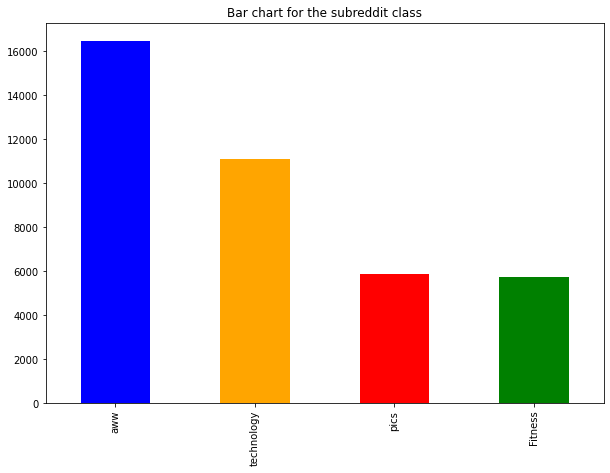

In [0]:
# Plot the distribution of subreddits
ax, fig = plt.subplots(figsize=(10, 7))
subreddit_class = data.subreddit.value_counts()
subreddit_class.plot(kind= 'bar', color = ["blue", "orange", "red", "green"])
plt.title('Bar chart for the subreddit class')
plt.show()

In [0]:
for i in ['Fitness', 'technology', 'pics', 'aww']:
    print(round(sum(data.subreddit == i) / data.shape[0] * 100,2), "percent of posts are in", i, '\n')

14.67 percent of posts are in Fitness 

28.34 percent of posts are in technology 

15.02 percent of posts are in pics 

41.97 percent of posts are in aww 



From the results, 14.67 percent of posts belong to r/Fitness, 28.34 percent of posts belong to r/technology, 15.02 percent of subreddits belong to r/pics, 41.97 percent of posts belong to r/aww.

In [0]:
# Use Shannon entropy to define a function as a measure of balance.
# Reference: https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance
def balance(seq):

    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)

    H = -sum([(count/n) * np.log((count/n)) for clas,count in classes]) #shannon entropy
    return H/np.log(k)

In [0]:
Blc = round(balance(data.subreddit),2)
Blc

0.93

Since the Shannon entropy score is near 1, and the number of posts of subreddit with most posts is just twice as that of subreddit with the least posts, we can say that my dataset is balanced.

### Check the url column

In [0]:
pd.set_option('display.max_rows', 200)

In [0]:
# Check the law of urls for each subreddit
url_class = pd.DataFrame({'pics': data[data.subreddit=='pics']['url'].reset_index(drop=True), 
                          'Fitness': data[data.subreddit=='Fitness']['url'].reset_index(drop=True), 
                          'aww': data[data.subreddit=='aww']['url'].reset_index(drop=True), 
                          'technology': data[data.subreddit=='technology']['url'].reset_index(drop=True)})
url_class.head(200)

,pics,Fitness,aww,technology
0,https://i.redd.it/j6rqqthwcp721.jpg,https://www.reddit.com/r/Fitness/comments/abd2...,https://i.redd.it/wvu0j48vdp721.jpg,https://emojipedia-us.s3.dualstack.us-west-1.a...
1,https://i.redd.it/063lwxm0dp721.jpg,https://www.reddit.com/r/Fitness/comments/abd5...,https://i.redd.it/m630oz82ep721.jpg,https://brainworldmagazine.com/transposed-mind...
2,https://i.redd.it/nkcs1p8adp721.jpg,https://www.reddit.com/r/Fitness/comments/abdc...,https://i.redd.it/c0pbypcuep721.jpg,https://www.reddit.com/r/technology/comments/a...
3,https://i.redd.it/kphnhymddp721.jpg,https://www.reddit.com/r/Fitness/comments/abdd...,https://i.redd.it/6vub1qhsfp721.jpg,https://emojipedia-us.s3.dualstack.us-west-1.a...
4,https://i.redd.it/jzyd4nhodp721.jpg,https://www.reddit.com/r/Fitness/comments/abdh...,https://imgur.com/nynLKWL,https://www.reddit.com/r/technology/comments/a...
5,https://i.redd.it/bvxz0wlbep721.jpg,https://www.reddit.com/r/Fitness/comments/abdq...,https://v.redd.it/luwzyy3ihp721,https://emojipedia-us.s3.dualstack.us-west-1.a...
6,https://i.redd.it/op5ytjmmfp721.jpg,https://www.reddit.com/r/Fitness/comments/abdx...,https://v.redd.it/wtjuhovapc721,https://emojipedia-us.s3.dualstack.us-west-1.a...
7,https://i.redd.it/ppvhacj4gp721.jpg,https://www.reddit.com/r/Fitness/comments/abdy...,https://i.redd.it/0ia59ye1ip721.jpg,https://emojipedia-us.s3.dualstack.us-west-1.a...
8,https://i.redd.it/0r9omph5hp721.jpg,https://www.reddit.com/r/Fitness/comments/abe0...,https://v.redd.it/s5k90hkaip721,https://www.reddit.com/r/technology/comments/a...
9,https://i.redd.it/vkq75ishhp721.jpg,https://www.reddit.com/r/Fitness/comments/abe0...,https://i.redd.it/uhdj5yboip721.jpg,https://arstechnica.com/gadgets/2018/12/june-p...


As we can see, in subreddit r/pics and r/aww, most urls start with 'https://i.redd.it/' and end with '721.jpg, or start with 'https://imgur.com; in subreddit r/Fitness, all urls include 'Fitness/comments'; in r/technology, the urls are random urls without any law. <br>
Based on the analysis, we can extract the basic law from the urls of each subreddit. For example, if there is 'Fitness' in url, we can encode the post as 'a', if there is like 'https://i.redd.it/%'+'%21.jpg' or like 'https://imgur.com%', encode the post as 'b'; else, encode as 'c'. Then we can use one-hot-encoding to use this feature.

In [0]:
# deafine a function to encode the url column.
def check_url(url):
    if 'Fitness' in url:
        return 'a'
    elif 'https://i.redd.it/' and '21.jpg' in url:
        return 'b'
    else:
        return 'c'

In [0]:
data['url_encode'] = data.apply(lambda row: check_url(row['url']), axis=1)
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,url_encode
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg,b
5,abcv7e,RyanGwood12,1546300923,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg,b
13,abcvty,popedotninja,1546301036,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg,b
14,abcvv8,[deleted],1546301042,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg,b
20,abcwfb,wearestardust24,1546301142,pics,Adult male polar bear. Photo: Paul Nicklen,4,69,,https://i.redd.it/jzyd4nhodp721.jpg,b


### Check the productive authors  and their preference for specific topics 

In [0]:
# Build a new df with author as index and the total number of subreddits the author posted and the total number of posts he made.
author_df = data.groupby('author')\
                .agg({'subreddit':pd.Series.nunique,
                      'id':pd.Series.count})\
                .rename(columns={'subreddit': 'num_classes',
                                 'id': 'num_posts'})\
                .sort_values('num_posts', ascending=False)

In [0]:
author_df.drop(['[deleted]'], inplace = True)

In [0]:
author_df.head()

,num_classes,num_posts
author,,
GriffonsChainsaw,1,256
ShiekhW,1,215
mvea,1,110
robbiewill4,1,109
tarifrechner,1,103


In [0]:
author_df.describe()

,num_classes,num_posts
count,22608.000000,22608.000000
mean,1.014243,1.412553
std,0.120712,3.515217
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,3.000000,256.000000


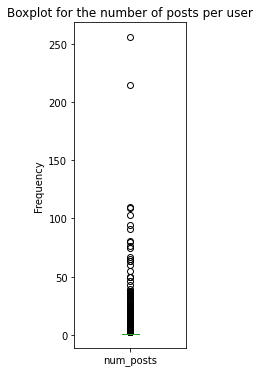

In [0]:
author_df.num_posts.plot(kind='box', vert=True, figsize=(2,6), title='Boxplot for the number of posts per user')
plt.ylabel('Frequency')
plt.show()

From the five-number summary and the box plot of the number of posts per user, we can see that **most users only post in one subreddit**, and **more than 75% of users post only 1 post**.

In [0]:
author_df.num_classes.value_counts()

1    22292
2      310
3        6
Name: num_classes, dtype: int64

In [0]:
author_gt_1 = list(author_df[author_df.num_posts>1].index)

In [0]:
len(author_gt_1)

3036

Here we can see, only 310 users post in two subreddits and 6 users post in 3 subreddits in my dataset. And I also **extract the authors who posted more than 1 posts**, which I will use in my model later.

### Convert UTC timestamp into valid datetime 

In [0]:
# Convert the created_utc to standard datetime.
data.created_utc = pd.to_datetime(data.created_utc, unit = 's')

In [0]:
# Ignore the %H:%m:%s
data['created_utc'] = data['created_utc'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,url_encode
1,abcuz2,mikebeingfrank,2019-01-01,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg,b
5,abcv7e,RyanGwood12,2019-01-01,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg,b
13,abcvty,popedotninja,2019-01-01,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg,b
14,abcvv8,[deleted],2019-01-01,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg,b
20,abcwfb,wearestardust24,2019-01-01,pics,Adult male polar bear. Photo: Paul Nicklen,4,69,,https://i.redd.it/jzyd4nhodp721.jpg,b


In [0]:
# Check the size of each subreddit in each day
data_time = data.groupby(['created_utc', 'subreddit']).size()

In [0]:
# Convert the Series to a dataframe with date as index and four subreddits as columns
idx = data_time.index.levels
c = len(idx[1])
data_time = pd.DataFrame(data_time.values.reshape(-1,c),index=idx[0].values, columns=idx[1].values)

In [0]:
data_time.head()

,Fitness,aww,pics,technology
2019-01-01,143,599,273,218
2019-01-02,188,548,242,334
2019-01-03,218,467,185,393
2019-01-04,212,440,182,419
2019-01-05,179,567,202,222


Text(0.5, 0, 'Day')

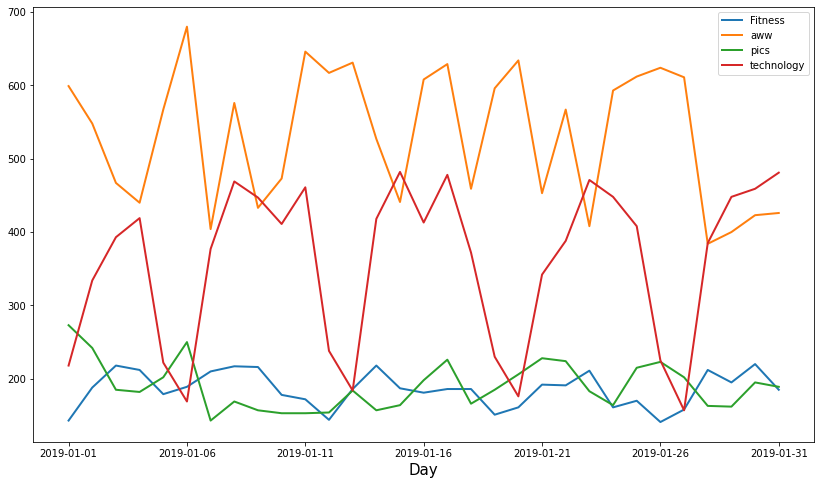

In [0]:
data_time.plot(figsize=(14,8), linewidth=2, fontsize=10)
plt.xlabel('Day', fontsize=15)

From the time series data for these four catagories, there is no obvious tendency that the number of posts for each subreddit is increasing or decreasing. The only thing we can see is that the number of posts in r/aww and r/technology is more than that in the other two subreddits. So that when building the model, **we can remove the time feature**. 

### Generate the insight from title and selftext column

In [0]:
# Combine the title column and the selftext column
data['text'] = data['title'] + ' ' + data['selftext']

In [0]:
# Remove the [deleted] string in text column
data['text'] = data['text'].map(lambda x: x.lstrip('[deleted]').rstrip('[deleted]'))
# Remove any remaining non-letters
data['text'] = data['text'].str.replace("[^a-zA-Z ]", "")
df = data[['author', 'num_comments', 'score', 'text', 'url_encode', 'subreddit']]
df.head()

,author,num_comments,score,text,url_encode,subreddit
1,mikebeingfrank,4,5,In an average wage worker had to clock hours...,b,pics
5,RyanGwood12,12,0,Heres a reminder to grab one of these for a be...,b,pics
13,popedotninja,5,5,My best photo of,b,pics
14,[deleted],3,46,Have a happy you sexy people,b,pics
20,wearestardust24,4,69,Adult male polar bear Photo Paul Nicklen,b,pics


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000.]), <a list of 9 Text major ticklabel objects>)

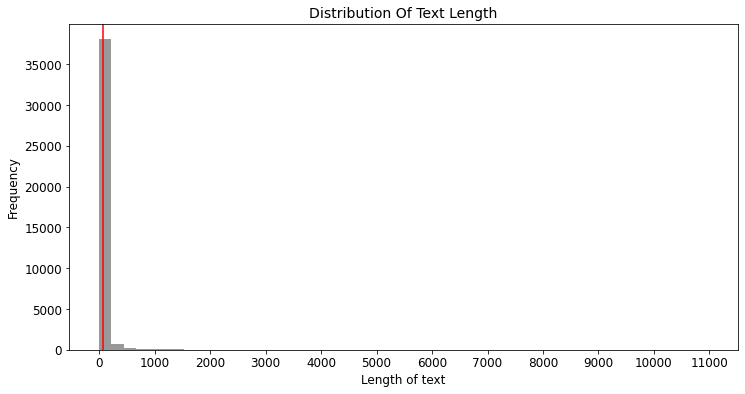

In [0]:
# Plot the length distribution of the texts of each post
x_len = np.array([len(i) for i in data['text']])

plt.figure(figsize = (12,6))
sns.distplot(x_len, kde = False, color = "black")
plt.axvline(np.mean(x_len), color = "red")
plt.title("Distribution Of Text Length", size = 14)
plt.xlabel("Length of text", size = 12)
plt.ylabel("Frequency", size = 12)
plt.xticks(np.arange(0,12000,1000), size = 12)
plt.yticks(size = 12)

In [0]:
# Build a new column containing the length of texts of each post.
df['text_length'] = x_len
# check the mean length of texts feature for each subreddit
df.groupby('subreddit', as_index=False)['text_length'].mean()

,subreddit,text_length
0,Fitness,149.051754
1,aww,48.996298
2,pics,56.025437
3,technology,65.132698


From the mean leangth of text for each subreddit, we can see that there is distinct difference between the mean length of 'Fitness' and others, which to say, the length of text for each post could also be used as a feature to do classification.

In [0]:
def frenquency_words(df, classes):
    vectorizer = CountVectorizer(stop_words = "english")
    sub_df = df[df.subreddit==classes]
    vec_sub = vectorizer.fit_transform(sub_df["text"])
    
    class_vectorized = pd.DataFrame(vec_sub.toarray(), columns = vectorizer.get_feature_names())
    vectorized_sub = pd.DataFrame(class_vectorized.sum().sort_values(ascending = False).head(50))
        
    fig = plt.figure(figsize = (14,8), facecolor = "white")
    # Creating the graph
    sns.barplot(x = 0, y = vectorized_sub.index, data = vectorized_sub, palette = "deep")
    plt.title(f"Most Common Words From {classes}", size = 15)
    plt.xlabel("Number Of Occurences", size = 12)
    plt.ylabel("Word", size = 12)
    plt.xticks(size = 10)
    plt.yticks(size = 10)

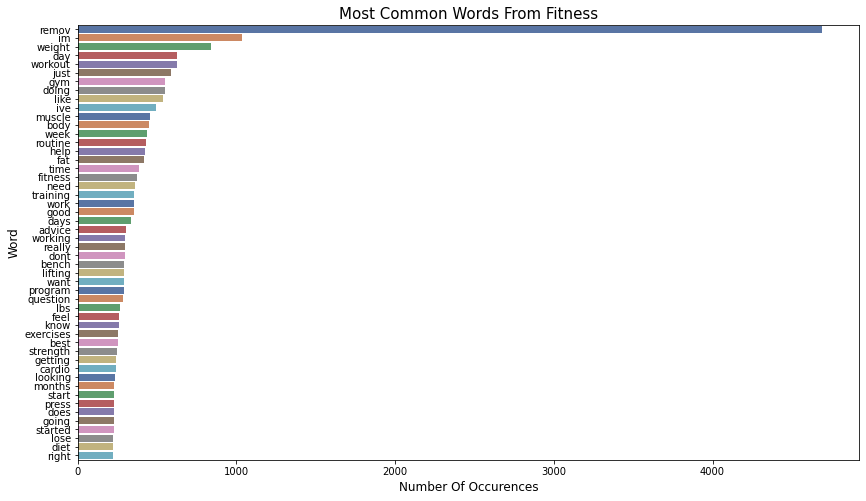

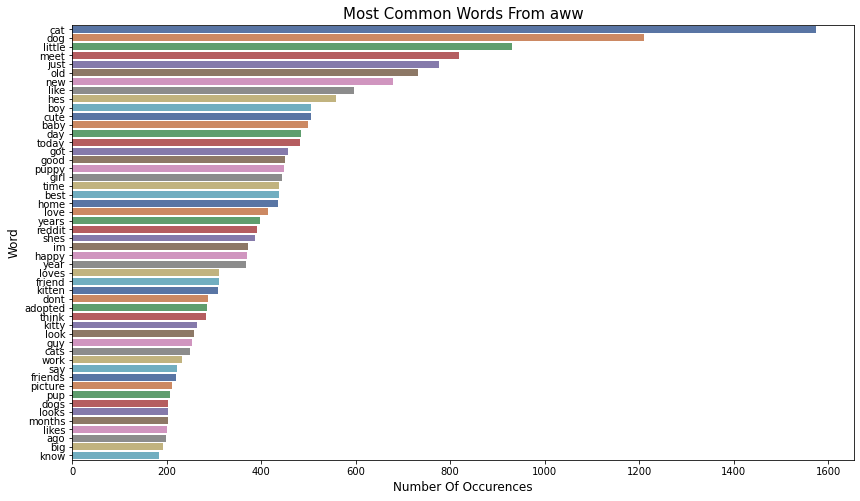

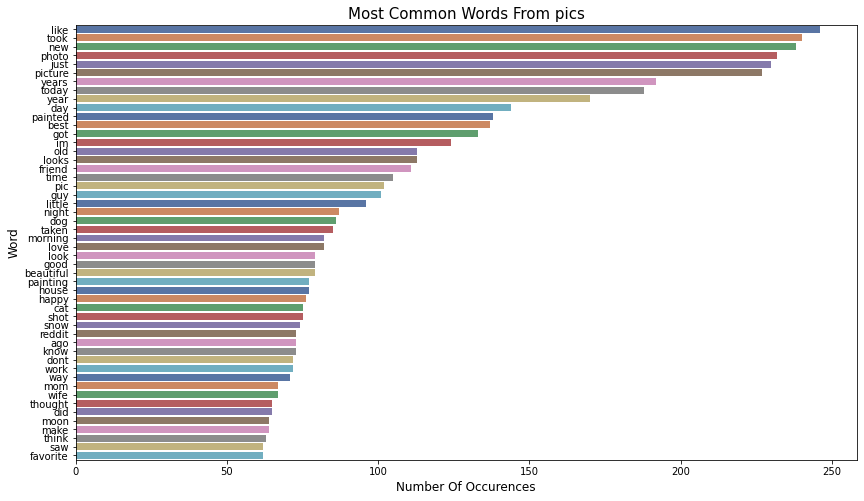

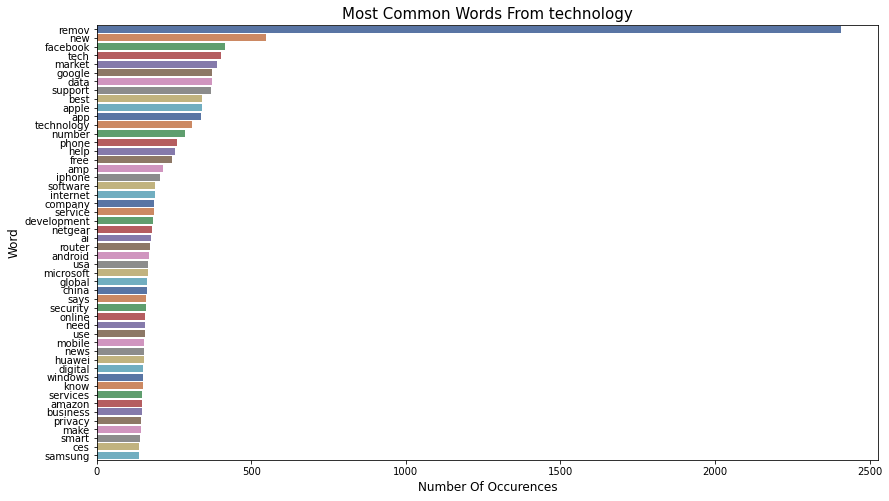

In [0]:
for i in ['Fitness', 'aww', 'pics', 'technology']:
    frenquency_words(df, i)

From the most common words of four subreddits, we can see there are many identical words in all four subreddits, which may not be very useful for classification prediction. There are some words should be included in the stopwords set like 'new', 'old', 'good'.

In [0]:
nltk.download("stopwords")
# Update the stopwords with the most commom frequency words in four subreddits.
new_stopwords = ["like", "new", "old", "good", "day", "ago"]

stopwords = stopwords.words('english')

stopwords.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Also from the plots of most frequency words, we can see that some words are in different form like 'ing' or 's', we should lemmatize these words in order to make our text more generalized.

In [0]:
# Copy from Lab tutorial
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

In [0]:
nltk.download('wordnet')
myFilter = RegexTokenizer() | LowercaseFilter() | StopFilter() | CustomFilter(WordNetLemmatizer().lemmatize)

lem_posts = []

for post in df["text"]:
    lem_posts.append(" ".join([token.text for token in myFilter(post)]))
    
# Appending the lemmatized posts to the dataframe

df["lemmatized_text"] = lem_posts

df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,author,num_comments,score,text,url_encode,subreddit,text_length,lemmatized_text
1,mikebeingfrank,4,5,In an average wage worker had to clock hours...,b,pics,186,average wage worker had clock hour afford prog...
5,RyanGwood12,12,0,Heres a reminder to grab one of these for a be...,b,pics,102,here reminder grab one these before bednext mo...
13,popedotninja,5,5,My best photo of,b,pics,18,my best photo
14,[deleted],3,46,Have a happy you sexy people,b,pics,30,happy sexy people
20,wearestardust24,4,69,Adult male polar bear Photo Paul Nicklen,b,pics,41,adult male polar bear photo paul nicklen


## Part 3: Classification

In this part, I will use four algorithms (**Logistic Regression, kNN, Naive Bayes, Random Forest**) to predict three kinds of datasets: **dataset with only text features**, **dataset with the prediction of text features and other features**, **dataset with all features**, then compare the performance between four algorithms and three type of feature sets. I got this idea by a post in stackexchange [Text categorization: combining different kind of features](https://datascience.stackexchange.com/a/9642). <br>
I dealt with text features mainly by bag-of-words model, then also compare the results with mdoels build by tf-idf text features.

In [0]:
!pip install scikit-learn==0.20.0
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
!pip install xgboost
from xgboost import XGBClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest

import matplotlib.gridspec as gridspec

In [0]:
import sklearn
sklearn.__version__

'0.20.0'

### (1) Fit models with only texts of posts

In [0]:
# Extract targets from the dataset
y = df.subreddit

In [0]:
# Split the text feature set by 70/30
X_train, X_test, y_train, y_test = train_test_split(df["lemmatized_text"], y, random_state = 42, test_size=0.33, stratify = y)

In [0]:
# Define a function with pipeline and gridsearchcv to tune the necessary parameters
def build_model(model, parameters, cv, df, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
                         ("count", CountVectorizer(max_features=500)), 
                         ("model", model)])
    gs = GridSearchCV(pipeline, parameters, cv = cv, n_jobs=-1)
    %time gs.fit(X_train, y_train)
    
    # Predict
    train_pred = gs.predict(X_train)
    test_pred = gs.predict(X_test)
    
    # get the prediction of probability of each subreddit
    proba = gs.predict_proba(df)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    #f1 = f1_score(y_test, test_pred, average = 'micro')
    cm = confusion_matrix(y_test, test_pred)
    c_report = classification_report(y_test, test_pred, output_dict=True)
    
    print("The train and test accuracies are:", train_acc, "and", test_acc)
    print("The output for the classification report:\n", pd.DataFrame(c_report).transpose())
    
    ax = plt.subplot()
    sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt=".0f")
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fitness', 'aww', 'pics', 'technology']); ax.yaxis.set_ticklabels(['Fitness', 'aww', 'pics', 'technology']);
    
    return gs, train_acc, test_acc, c_report, proba

### Logistic Regression

CPU times: user 3.67 s, sys: 447 ms, total: 4.12 s
Wall time: 50.5 s
The train and test accuracies are: 0.7900380228136882 and 0.7786784004940559
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.867417  0.933158  0.899087   1900.0
aww            0.731782  0.925326  0.817251   5437.0
pics           0.617070  0.274923  0.380377   1946.0
technology     0.867424  0.748570  0.803626   3671.0
micro avg      0.778678  0.778678  0.778678  12954.0
macro avg      0.770923  0.720494  0.725085  12954.0
weighted avg   0.772883  0.778678  0.759764  12954.0


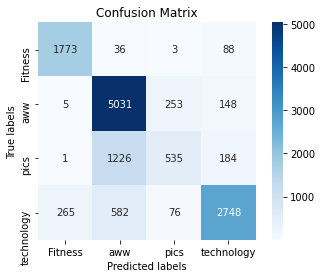

In [0]:
# Tune the ngram and max_df parameters in bag-of-words model and C in Logistic Regression model.
lr_count_params = {"count__max_df": (0.5, 0.75, 1), "count__ngram_range": [(1,1), (1,2), (1,3)],
                   "model__C": [0.1, 1, 2]}
lr_model, lr_train_acc, lr_test_acc, lr_c_report, lr_proba = build_model(LogisticRegression(), lr_count_params, 3, df["lemmatized_text"], X_train, y_train, X_test, y_test)

In [0]:
lr_model.best_estimator_.steps

[('count',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.5, max_features=500, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('model',
  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False))]

### KNN

CPU times: user 1.41 s, sys: 329 ms, total: 1.74 s
Wall time: 1min 36s
The train and test accuracies are: 0.7636121673003802 and 0.7043384282846997
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.821903  0.813684  0.817773   1900.0
aww            0.738011  0.800993  0.768213   5437.0
pics           0.382642  0.459918  0.417736   1946.0
technology     0.821744  0.634160  0.715867   3671.0
micro avg      0.704338  0.704338  0.704338  12954.0
macro avg      0.691075  0.677189  0.679897  12954.0
weighted avg   0.720659  0.704338  0.707998  12954.0


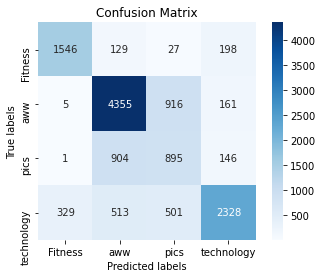

In [0]:
# tune the max_df and n_gram parameters in bad-of-words model
knn_count_params = {"count__max_df": (0.5, 0.75, 1), "count__ngram_range": [(1,1), (1,2), (1,3)]}
knn_model, knn_train_acc, knn_test_acc, knn_c_report, knn_proba = build_model(KNeighborsClassifier(), knn_count_params, 3, df["lemmatized_text"], X_train, y_train, X_test, y_test)

In [0]:
knn_model.best_estimator_.steps

[('count',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.5, max_features=500, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('model',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'))]

Here we can see kNN algorithm has little overfitting problem.

### Naive Bayes

CPU times: user 1.47 s, sys: 31.5 ms, total: 1.5 s
Wall time: 15.2 s
The train and test accuracies are: 0.7670722433460077 and 0.7640111162575266
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.806680  0.838947  0.822497   1900.0
aww            0.741638  0.901232  0.813683   5437.0
pics           0.596717  0.261562  0.363701   1946.0
technology     0.822626  0.788341  0.805119   3671.0
micro avg      0.764011  0.764011  0.764011  12954.0
macro avg      0.741915  0.697521  0.701250  12954.0
weighted avg   0.752358  0.764011  0.744951  12954.0


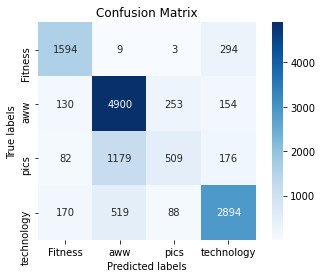

In [0]:
nb_count_params = {"count__max_df": (0.5, 0.75, 1), "count__ngram_range": [(1,1), (1,2), (1,3)]}
nb_model, nb_train_acc, nb_test_acc, nb_c_report, nb_proba = build_model(MultinomialNB(), nb_count_params, 3, df["lemmatized_text"], X_train, y_train, X_test, y_test)

In [0]:
nb_model.best_estimator_.steps

[('count',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.5, max_features=500, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

Naive Bayes gives pretty good results with very low run time.

### Random Forest

CPU times: user 34.3 s, sys: 331 ms, total: 34.6 s
Wall time: 4min 55s
The train and test accuracies are: 0.9004942965779468 and 0.773351860429211
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.917327  0.852632  0.883797   1900.0
aww            0.747006  0.894979  0.814325   5437.0
pics           0.545217  0.322199  0.405039   1946.0
technology     0.824347  0.791338  0.807505   3671.0
micro avg      0.773352  0.773352  0.773352  12954.0
macro avg      0.758475  0.715287  0.727667  12954.0
weighted avg   0.763592  0.773352  0.761098  12954.0


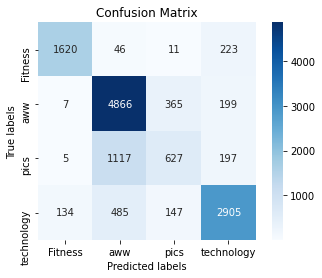

In [0]:
# Tune the max_df and n_gram parameters in bag-of-words model and n_estimator in random forest
rf_count_params = {"count__max_df": (0.5, 0.75, 1), "count__ngram_range": [(1,1), (1,2), (1,3)],
                   "model__n_estimators": [100, 150]}
rf_model, rf_train_acc, rf_test_acc, rf_c_report, rf_proba = build_model(RandomForestClassifier(n_jobs=-1), rf_count_params, 3, df["lemmatized_text"], X_train, y_train, X_test, y_test)

In [0]:
rf_model.best_estimator_.steps

[('count',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.5, max_features=500, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('model',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

Random forest has the most serious overfitting problem among the four algorithms.

### Compare the models' performance 

In [0]:
# Select Precision, Accuracy and f1-score as my evaluation matrix
precision = [lr_c_report['macro avg']['precision'], 
             knn_c_report['macro avg']['precision'], 
             nb_c_report['macro avg']['precision'], 
             rf_c_report['macro avg']['precision']]
acc = [lr_test_acc, knn_test_acc, nb_test_acc, rf_test_acc]
f1 = [lr_c_report['macro avg']['f1-score'], 
      knn_c_report['macro avg']['f1-score'], 
      nb_c_report['macro avg']['f1-score'], 
      rf_c_report['macro avg']['f1-score']]

In [0]:
# Compare the matrix scores among four different algorithms
Score_df = pd.DataFrame({'Precision':precision, 'Accuracy':acc, 'F1-Score':f1}, index = ['Logistic Regression', 'kNN', 'Naive Bayes', 'Random forest'])
Score_df.head()

,Precision,Accuracy,F1-Score
Logistic Regression,0.770923,0.778678,0.725085
kNN,0.691075,0.704338,0.679897
Naive Bayes,0.741915,0.764011,0.701250
Random forest,0.758475,0.773352,0.727667


Text(0.5, 1.0, 'F1-score Among Four Algorithms')

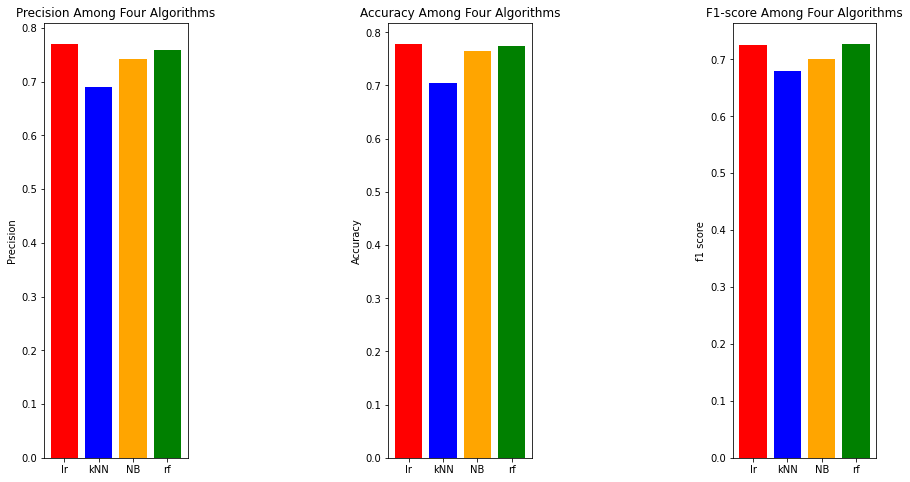

In [0]:
# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 6)
color = ['r', 'b', 'orange', 'g']

fig = plt.figure(figsize = (18,8))
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar([0,1,2,3], precision, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
#ax1.set_xticklabels(['lr', 'kNN', 'SVM', 'Xgboost'])
ax1.set_ylabel('Precision')
ax1.set_title('Precision Among Four Algorithms')

ax2 = fig.add_subplot(gs[0, 2])
ax2.bar([0,1,2,3], acc, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
#ax2.set_xticklabels(['lr', 'kNN', 'SVM', 'Xgboost'])
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Among Four Algorithms')

ax3 = fig.add_subplot(gs[0, 4])
ax3.bar([0,1,2,3], f1, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
#ax3.set_xticklabels(['lr', 'kNN', 'SVM', 'Xgboost'])
ax3.set_ylabel('f1 score')
ax3.set_title('F1-score Among Four Algorithms')

From the bar plots and the Score datafrmae for the four different algorithms, we can see that if we only use count vectorized texts as our feature, logistic regression outperforms the other three in both accuracy and precision, only random forest beats Logistic Regression in f1 score, but these two algorithms' performances are very similar. <br>
Considering the running and hyperparameter tuning speed, Logistic Regression uses only 1 minute to give the results, but random forest spends almost 5 minutes. Considering the effeciency and the accuracy trade-off, the logistic regression is the best model this time.

### (2) Use the predictions (subreddits and their correspondng probabilities) by text features as four features, together with other features to predict

In [0]:
# Apply one-hot-encoding to the author and choose the author with more than 1 posts to use
one_hot_author = pd.get_dummies(df.author, dtype=int)
one_hot_author = one_hot_author[author_gt_1]

In [0]:
one_hot_author.shape

(39254, 3036)

In [0]:
# One hot encode the url_encode column
one_hot_url = pd.get_dummies(df['url_encode'], dtype = int)
one_hot_url.shape

(39254, 3)

In [0]:
def build_model_1(model, params, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(estimator = model, param_grid = params, n_jobs=-1)
    m = gs.fit(X_train, y_train)
    train_pred = m.predict(X_train)
    test_pred = m.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    #f1 = f1_score(y_test, test_pred, average = 'micro')
    cm = confusion_matrix(y_test, test_pred)
    c_report = classification_report(y_test, test_pred, output_dict=True)
    
    print("The train and test accuracies are:", train_acc, "and", test_acc)
    print("The output for the classification report:\n", pd.DataFrame(c_report).transpose())
    
    ax = plt.subplot()
    sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt=".0f")
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fitness', 'aww', 'pics', 'technology']); ax.yaxis.set_ticklabels(['Fitness', 'aww', 'pics', 'technology']);
    
    return m, train_acc, test_acc, c_report

In [0]:
# Convert the prediciton probabilites for 4 classes by four algorithms to dataframes
lr_proba_df = pd.DataFrame(lr_proba, columns = ['Fitness', 'aww', 'pics', 'technology']).astype(float).reset_index(drop=True)
knn_proba_df = pd.DataFrame(knn_proba, columns = ['Fitness', 'aww', 'pics', 'technology']).astype(float).reset_index(drop=True)
nb_proba_df = pd.DataFrame(nb_proba, columns = ['Fitness', 'aww', 'pics', 'technology']).astype(float).reset_index(drop=True)
rf_proba_df = pd.DataFrame(rf_proba, columns = ['Fitness', 'aww', 'pics', 'technology']).astype(float).reset_index(drop=True)

### Logistic Regression

In [0]:
# Combine the one_hot_author, lr_proba_df, one_hot_url and numeric features.
lr_df = pd.concat([one_hot_author.reset_index(drop=True), lr_proba_df, one_hot_url.reset_index(drop=True), df[['num_comments', 'score', 'text_length']].reset_index(drop=True)], axis = 1)

In [0]:
X_train_2_lr, X_test_2_lr, y_train_2_lr, y_test_2_lr = train_test_split(lr_df, y, random_state = 42, test_size=0.33, stratify = y)

The train and test accuracies are: 0.8561977186311787 and 0.8513200555812876
The output for the classification report:
               precision    recall  f1-score  support
Fitness        1.000000  1.000000  1.000000   1900.0
aww            0.800329  0.895715  0.845339   5437.0
pics           0.701463  0.369476  0.484012   1946.0
technology     0.897312  0.964042  0.929481   3671.0
micro avg      0.851320  0.851320  0.851320  12954.0
macro avg      0.849776  0.807308  0.814708  12954.0
weighted avg   0.842247  0.851320  0.837589  12954.0


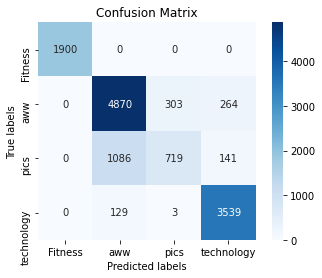

In [0]:
# Train a logistic regression model with parameter C tuned
lr_model_2, lr_train_acc_2, lr_test_acc_2, lr_c_report_2 = build_model_1(LogisticRegression(), {'C':[0.1, 1, 2], 'solver': ['lbfgs']}, X_train_2_lr, X_test_2_lr, y_train_2_lr, y_test_2_lr)

In [0]:
lr_model_2.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Results of Logistic Regression improved based on this feature set.

### kNN

In [0]:
# Combine the one_hot_author, knn_proba_df, one_hot_url and numeric features.
knn_df = pd.concat([one_hot_author.reset_index(drop=True), knn_proba_df, one_hot_url.reset_index(drop=True), df[['num_comments', 'score', 'text_length']].reset_index(drop=True)], axis = 1)
X_train_2_knn, X_test_2_knn, y_train_2_knn, y_test_2_knn = train_test_split(knn_df, y, random_state = 42, test_size=0.33, stratify = y)

The train and test accuracies are: 0.9988973384030418 and 0.8311718388142658
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.960647  0.937895  0.949134   1900.0
aww            0.795777  0.908038  0.848209   5437.0
pics           0.538793  0.385406  0.449371   1946.0
technology     0.941479  0.898393  0.919431   3671.0
micro avg      0.831172  0.831172  0.831172  12954.0
macro avg      0.809174  0.782433  0.791536  12954.0
weighted avg   0.822644  0.831172  0.823280  12954.0


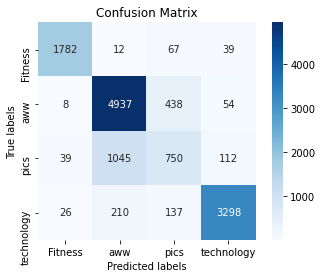

In [0]:
# train a knn model with parameters n_neighbors, weights tuned
knn_model_2, knn_train_acc_2, knn_test_acc_2, knn_c_report_2 = build_model_1(KNeighborsClassifier(), {'n_neighbors':[5,6,7], 'weights':['uniform', 'distance'], 'n_jobs':[-1]}, X_train_2_knn, X_test_2_knn, y_train_2_knn, y_test_2_knn)

In [0]:
knn_model_2.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='distance')

KNN still has overfitting problem.

### Naive Bayes

In [0]:
# Combine the one_hot_author, nb_proba_df, one_hot_url and numeric features.
nb_df = pd.concat([one_hot_author.reset_index(), nb_proba_df, one_hot_url.reset_index(drop=True), df[['num_comments', 'score', 'text_length']].reset_index()], axis = 1)
X_train_2_nb, X_test_2_nb, y_train_2_nb, y_test_2_nb = train_test_split(nb_df, y, random_state = 42, test_size=0.33, stratify = y)

The train and test accuracies are: 0.2225855513307985 and 0.22263393546394936
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.216222  0.990526  0.354960   1900.0
aww            0.842160  0.149163  0.253438   5437.0
pics           0.149281  0.042652  0.066347   1946.0
technology     0.039546  0.029420  0.033739   3671.0
micro avg      0.222634  0.222634  0.222634  12954.0
macro avg      0.311802  0.302940  0.177121  12954.0
weighted avg   0.418814  0.222634  0.177963  12954.0


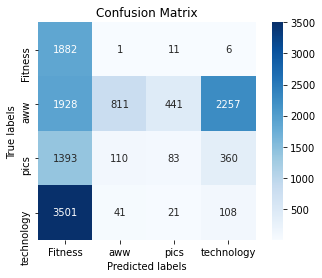

In [0]:
nb_model_2, nb_train_acc_2, nb_test_acc_2, nb_c_report_2 = build_model_1(MultinomialNB(), {'alpha':[1.0]}, X_train_2_nb, X_test_2_nb, y_train_2_nb, y_test_2_nb)

NB is very bad this time, I guess it is becasue the features can not meet the independence requirement.

### Random Forest

In [0]:
# Combine the one_hot_author, rf_proba_df, one_hot_url and numeric features.
rf_df = pd.concat([one_hot_author.reset_index(), rf_proba_df, one_hot_url.reset_index(drop=True), df[['num_comments', 'score', 'text_length']].reset_index()], axis = 1)
X_train_2_rf, X_test_2_rf, y_train_2_rf, y_test_2_rf = train_test_split(rf_df, y, random_state = 42, test_size=0.33, stratify = y)

The train and test accuracies are: 1.0 and 0.8901497606916783
The output for the classification report:
               precision    recall  f1-score  support
Fitness        1.000000  1.000000  1.000000   1900.0
aww            0.867613  0.888358  0.877863   5437.0
pics           0.665733  0.610997  0.637192   1946.0
technology     0.975952  0.983928  0.979924   3671.0
micro avg      0.890150  0.890150  0.890150  12954.0
macro avg      0.877325  0.870821  0.873745  12954.0
weighted avg   0.887405  0.890150  0.888545  12954.0


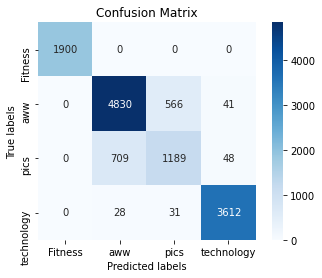

In [0]:
# Train a random forest model with n_estimators tuned.
rf_model_2, rf_train_acc_2, rf_test_acc_2, rf_c_report_2 = build_model_1(RandomForestClassifier(n_jobs=-1), 
                                                                         {"n_estimators": [100, 150]}, 
                                                                         X_train_2_rf, X_test_2_rf, y_train_2_rf, y_test_2_rf)

In [0]:
rf_model_2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

The accuracy of random forest is highest, even though there is little overfitting problem, but it is acceptable.

### Results compare. 

In [0]:
precision_2 = [lr_c_report_2['macro avg']['precision'], 
               knn_c_report_2['macro avg']['precision'], 
               nb_c_report_2['macro avg']['precision'],
               rf_c_report_2['macro avg']['precision']]
acc_2 = [lr_test_acc_2, knn_test_acc_2, nb_test_acc_2, rf_test_acc_2]
f1_2 = [lr_c_report_2['macro avg']['f1-score'], 
        knn_c_report_2['macro avg']['f1-score'], 
        nb_c_report_2['macro avg']['f1-score'], 
        rf_c_report_2['macro avg']['f1-score']]

In [0]:
Score_df_2 = pd.DataFrame({'Precision':precision_2, 'Accuracy':acc_2, 'F1-Score':f1_2}, index = ['Logistic Regression', 'kNN', 'Naive Bayes', 'Random forest'])
Score_df_2.head()

,Precision,Accuracy,F1-Score
Logistic Regression,0.849776,0.851320,0.814708
kNN,0.809174,0.831172,0.791536
Naive Bayes,0.311802,0.222634,0.177121
Random forest,0.877325,0.890150,0.873745


Text(0.5, 1.0, 'F1-score Among Four Algorithms')

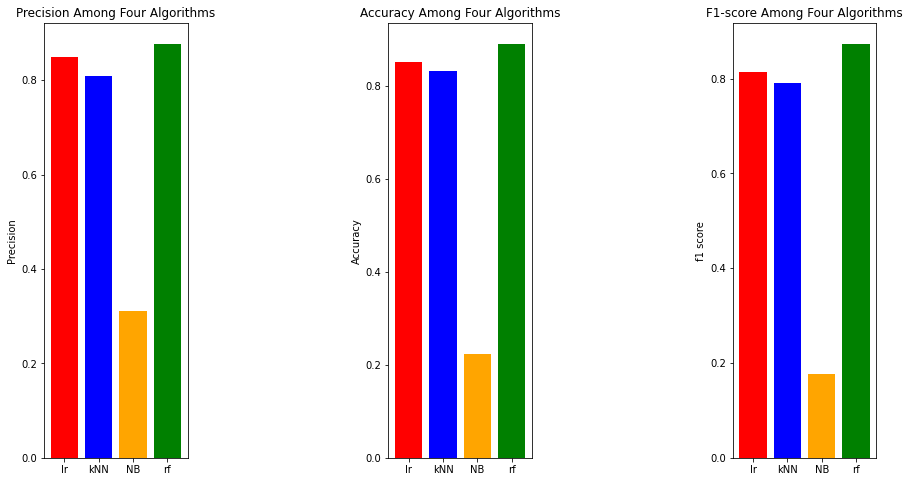

In [0]:
# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 6)
color = ['r', 'b', 'orange', 'g']

fig = plt.figure(figsize = (18,8))
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar([0,1,2,3], precision_2, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
ax1.set_ylabel('Precision')
ax1.set_title('Precision Among Four Algorithms')

ax2 = fig.add_subplot(gs[0, 2])
ax2.bar([0,1,2,3], acc_2, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Among Four Algorithms')

ax3 = fig.add_subplot(gs[0, 4])
ax3.bar([0,1,2,3], f1_2, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
ax3.set_ylabel('f1 score')
ax3.set_title('F1-score Among Four Algorithms')

The results show that **Random Forest performs** best among the four algorithms in all three evaluation matrix. But random forest has **a little overfitting** problem (train acc = 1 but test acc is only 89%). Logistic Regression performs also very good without overfitting.

### (3) Combine text feature and other features to fit models

In [0]:
nltk.download('punkt')
vectorizer = CountVectorizer(max_features = 500, max_df=0.5, ngram_range=(1,1), strip_accents='unicode', tokenizer=word_tokenize)
Countvectorized = vectorizer.fit_transform(df.lemmatized_text.values)
Count_df = pd.DataFrame(Countvectorized.toarray())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
final_df = pd.concat([one_hot_author.reset_index(drop=True), Count_df.reset_index(drop=True), one_hot_url.reset_index(drop=True), df[['num_comments', 'score', 'text_length']].reset_index(drop=True)], axis=1)
final_df.shape

(39254, 3542)

In [0]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(final_df, y, random_state = 42, test_size=0.33, stratify = y)

The train and test accuracies are: 0.873384030418251 and 0.8645206113941639
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.992134  0.995789  0.993958   1900.0
aww            0.835524  0.888541  0.861218   5437.0
pics           0.713818  0.448613  0.550962   1946.0
technology     0.891390  0.981476  0.934267   3671.0
micro avg      0.864521  0.864521  0.864521  12954.0
macro avg      0.858217  0.828605  0.835101  12954.0
weighted avg   0.856043  0.864521  0.854781  12954.0


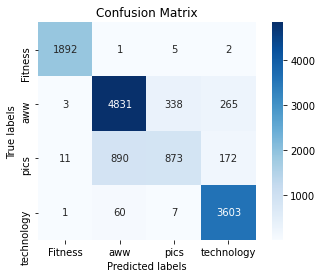

In [0]:
lr_model_1, lr_train_acc_1, lr_test_acc_1, lr_c_report_1 = build_model_1(LogisticRegression(n_jobs = -1), {'C':[0.1,1,2]}, X_train_1, X_test_1, y_train_1, y_test_1)

The train and test accuracies are: 0.8572623574144487 and 0.8142658638258453
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.947311  0.908421  0.927458   1900.0
aww            0.793648  0.887070  0.837763   5437.0
pics           0.486045  0.366906  0.418155   1946.0
technology     0.916062  0.894852  0.905333   3671.0
micro avg      0.814266  0.814266  0.814266  12954.0
macro avg      0.785767  0.764312  0.772177  12954.0
weighted avg   0.804668  0.814266  0.807032  12954.0


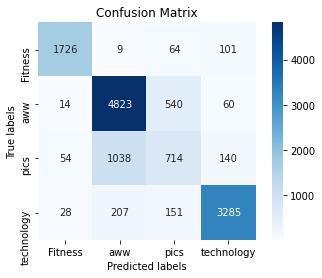

In [0]:
knn_model_1, knn_train_acc_1, knn_test_1, knn_c_report_1 = build_model_1(KNeighborsClassifier(), {'n_neighbors':[5,6,7], 'weights':['uniform', 'distance'], 'n_jobs':[-1]}, X_train_1, X_test_1, y_train_1, y_test_1)

The overfitting problem is decreasing this time for kNN.

The train and test accuracies are: 0.23007604562737644 and 0.2295815964180948
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.237741  0.992632  0.383606   1900.0
aww            0.903628  0.146588  0.252255   5437.0
pics           0.140260  0.055498  0.079529   1946.0
technology     0.054319  0.049850  0.051989   3671.0
micro avg      0.229582  0.229582  0.229582  12954.0
macro avg      0.333987  0.311142  0.191845  12954.0
weighted avg   0.450601  0.229582  0.188820  12954.0


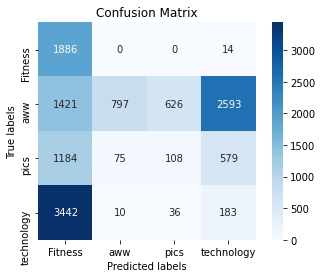

In [0]:
nb_model_1, nb_train_acc_1, nb_test_acc_1, nb_c_report_1 = build_model_1(MultinomialNB(), {'alpha':[1.0]}, X_train_1, X_test_1, y_train_1, y_test_1)

The train and test accuracies are: 0.9997338403041826 and 0.9072101281457465
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.999474  1.000000  0.999737   1900.0
aww            0.874286  0.928637  0.900642   5437.0
pics           0.756319  0.599692  0.668960   1946.0
technology     0.973494  0.990466  0.981907   3671.0
micro avg      0.907210  0.907210  0.907210  12954.0
macro avg      0.900893  0.879699  0.887811  12954.0
weighted avg   0.903040  0.907210  0.903402  12954.0


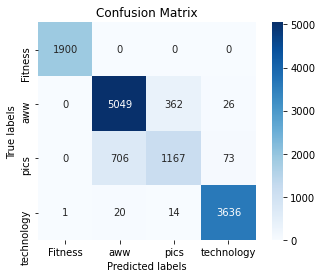

In [0]:
rf_model_1, rf_train_1, rf_test_1, rf_c_report_1 = build_model_1(RandomForestClassifier(n_jobs = -1), 
                                                                 {"n_estimators": [100, 150]}, 
                                                                 X_train_1, X_test_1, y_train_1, y_test_1)

In [0]:
precision_1 = [lr_c_report_1['macro avg']['precision'], 
               knn_c_report_1['macro avg']['precision'], 
               nb_c_report_1['macro avg']['precision'], 
               rf_c_report_1['macro avg']['precision']]
acc_1 = [lr_test_acc_1, knn_test_1, nb_test_acc_1, rf_test_1]
f1_1 = [lr_c_report_1['macro avg']['f1-score'], 
        knn_c_report_1['macro avg']['f1-score'], 
        nb_c_report_1['macro avg']['f1-score'], 
        rf_c_report_1['macro avg']['f1-score']]

In [0]:
Score_df_1 = pd.DataFrame({'Precision':precision_1, 'Accuracy':acc_1, 'F1-Score':f1_1}, index = ['Logistic Regression', 'kNN', 'Naive Bayes', 'Random forest'])
Score_df_1.head()

,Precision,Accuracy,F1-Score
Logistic Regression,0.858217,0.864521,0.835101
kNN,0.785767,0.814266,0.772177
Naive Bayes,0.333987,0.229582,0.191845
Random forest,0.900893,0.907210,0.887811


Text(0.5, 1.0, 'F1-score Among Four Algorithms')

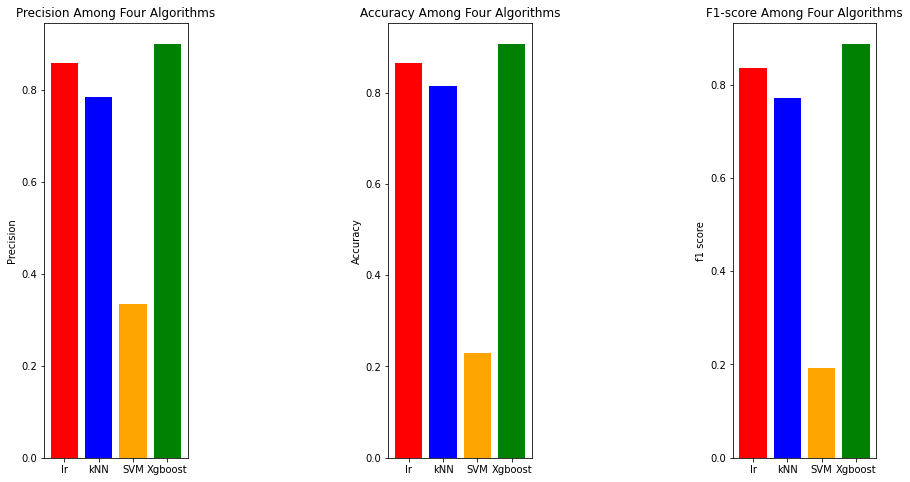

In [0]:
#Create 1x3 sub plots
gs = gridspec.GridSpec(1, 6)
color = ['r', 'b', 'orange', 'g']

fig = plt.figure(figsize = (18,8))
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar([0,1,2,3], precision_1, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
ax1.set_xticklabels(['lr', 'kNN', 'NB', 'rf'])
ax1.set_ylabel('Precision')
ax1.set_title('Precision Among Four Algorithms')

ax2 = fig.add_subplot(gs[0, 2])
ax2.bar([0,1,2,3], acc_1, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
ax2.set_xticklabels(['lr', 'kNN', 'NB', 'rf'])
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Among Four Algorithms')

ax3 = fig.add_subplot(gs[0, 4])
ax3.bar([0,1,2,3], f1_1, tick_label = ['lr', 'kNN', 'NB', 'rf'], color = color)
ax3.set_xticklabels(['lr', 'kNN', 'NB', 'rf'])
ax3.set_ylabel('f1 score')
ax3.set_title('F1-score Among Four Algorithms')

Before submitting, I found the xtick problem but I don't have enough time to rerun from beginning. The correct xtick is 'lr', 'kNN', 'NB', 'rf'. I have tried SVM and Xgboost, but at last I chose NB and random forest.

In [0]:
# Logistic Regression Scores
lr_acc = [lr_test_acc, lr_test_acc_2, lr_test_acc_1]
lr_precision = [lr_c_report['macro avg']['precision'], lr_c_report_2['macro avg']['precision'], lr_c_report_1['macro avg']['precision']]
lr_f1 = [lr_c_report['macro avg']['f1-score'], lr_c_report_2['macro avg']['f1-score'], lr_c_report_1['macro avg']['f1-score']]

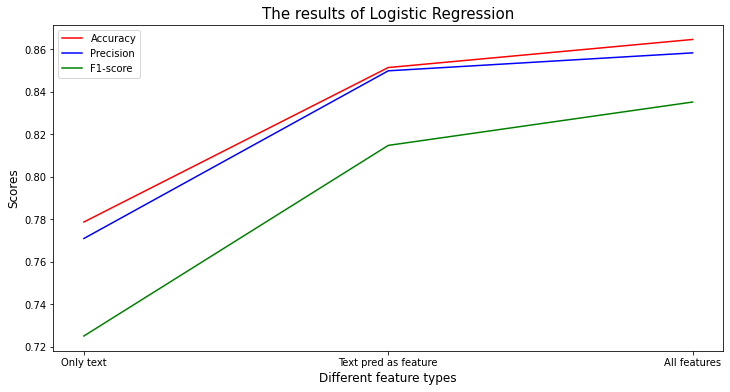

In [0]:
fig = plt.figure(figsize = (12,6))
plt.plot([0,1,2], lr_acc, c='r', label = 'Accuracy')
plt.plot([0,1,2], lr_precision, c='b', label = 'Precision')
plt.plot([0,1,2], lr_f1, c='g', label = 'F1-score')
plt.xticks(np.arange(3),('Only text', 'Text pred as feature', 'All features'))
plt.xlabel('Different feature types', size = 12)
plt.ylabel('Scores', size = 12)
plt.legend(loc = 2)
plt.title('The results of Logistic Regression', size = 15)
plt.show()

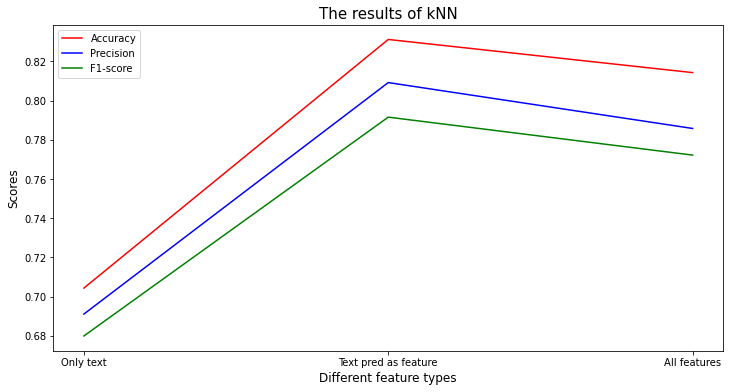

In [0]:
# knn Scores
knn_acc = [knn_test_acc, knn_test_acc_2, knn_test_1]
knn_precision = [knn_c_report['macro avg']['precision'], knn_c_report_2['macro avg']['precision'], knn_c_report_1['macro avg']['precision']]
knn_f1 = [knn_c_report['macro avg']['f1-score'], knn_c_report_2['macro avg']['f1-score'], knn_c_report_1['macro avg']['f1-score']]

fig = plt.figure(figsize = (12,6))
plt.plot([0,1,2], knn_acc, c='r', label = 'Accuracy')
plt.plot([0,1,2], knn_precision, c='b', label = 'Precision')
plt.plot([0,1,2], knn_f1, c='g', label = 'F1-score')
plt.xticks(np.arange(3),('Only text', 'Text pred as feature', 'All features'))
plt.xlabel('Different feature types', size = 12)
plt.ylabel('Scores', size = 12)
plt.legend(loc = 2)
plt.title('The results of kNN', size = 15)
plt.show()

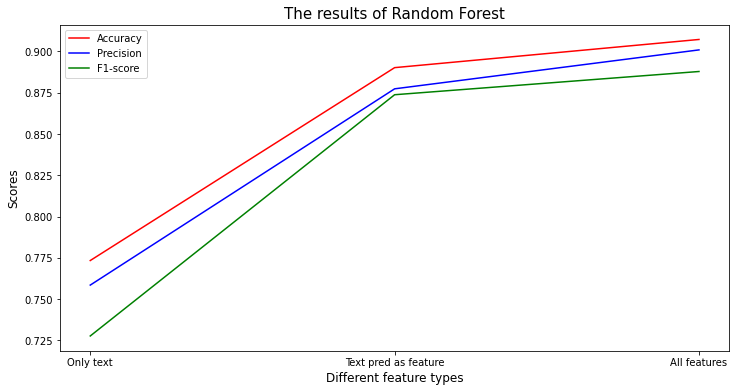

In [0]:
# Random Forest Scores
rf_acc = [rf_test_acc, rf_test_acc_2, rf_test_1]
rf_precision = [rf_c_report['macro avg']['precision'], rf_c_report_2['macro avg']['precision'], rf_c_report_1['macro avg']['precision']]
rf_f1 = [rf_c_report['macro avg']['f1-score'], rf_c_report_2['macro avg']['f1-score'], rf_c_report_1['macro avg']['f1-score']]

fig = plt.figure(figsize = (12,6))
plt.plot([0,1,2], rf_acc, c='r', label = 'Accuracy')
plt.plot([0,1,2], rf_precision, c='b', label = 'Precision')
plt.plot([0,1,2], rf_f1, c='g', label = 'F1-score')
plt.xticks(np.arange(3),('Only text', 'Text pred as feature', 'All features'))
plt.xlabel('Different feature types', size = 12)
plt.ylabel('Scores', size = 12)
plt.legend(loc = 2)
plt.title('The results of Random Forest', size = 15)
plt.show()

All in all, when we use the **Bag-of-words model** to deal with text features, and use **logistic regression, knn, Naive Bayes** and **Random Forest** to predict the class for each post, **bag-of-words with one-hot-encoding author features and other features together** will have the best performance among these three types of feature sets.<br>
I choose **Accuracy, Precision** and **f1-score** as evaluation matrix since accuracy shows the (true positive + true negative)/(true positive + true negative + false nagative + false positive), which is a important matric for classification problem when there is no obvious imbalance problem; precision is (true positive) / (true positive + false positive), which only care about the positive prediction. The positive prediction is what we want and what we can see from the result, so it is a clear matric to show the classification result; f1-score is the average of precision and recall, which has the property of both precision and recall. That's to say, f1-score reflects the most information. <br>
Based on all my implementation, the **Random Forest** with full feature set gives the **best classification results** (more than 90% Precision and Accuracy, even though there is a little overfitting problem, but not so serious, and if we tune all hyperparameters the overfitting problem would be avoid (Considering the time and memory limitation, I didn't tune many hyperparameters).

### Compare bag-of-words model with tf-idf model by Logistic Regression and Random forest since these two algorithms perform better above.

In [0]:
vectorizer_tfidf = TfidfVectorizer(max_features = 500, max_df=0.5, ngram_range=(1,1), strip_accents='unicode', tokenizer=word_tokenize)
Tfidfvectorized = vectorizer_tfidf.fit_transform(df.lemmatized_text.values)
Tfidf_df = pd.DataFrame(Tfidfvectorized.toarray())
Tfidf_df.shape

(39254, 500)

In [0]:
final_df_t = pd.concat([one_hot_author.reset_index(drop=True), Tfidf_df.reset_index(drop=True), one_hot_url.reset_index(drop=True), df[['num_comments', 'score', 'text_length']].reset_index(drop=True)], axis=1)

In [0]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(final_df_t, y, random_state = 42, test_size=0.33, stratify = y)

The train and test accuracies are: 0.8544866920152091 and 0.8475374401729195
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.995794  0.996842  0.996318   1900.0
aww            0.792374  0.909693  0.846990   5437.0
pics           0.768137  0.277492  0.407701   1946.0
technology     0.876309  0.980387  0.925431   3671.0
micro avg      0.847537  0.847537  0.847537  12954.0
macro avg      0.858153  0.791104  0.794110  12954.0
weighted avg   0.842355  0.847537  0.825130  12954.0


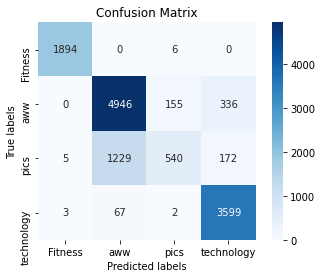

In [0]:
lr_model_3, lr_train_acc_3, lr_test_acc_3, lr_c_report_3 = build_model_1(LogisticRegression(n_jobs = -1), 
                                                                         {'C':[0.1,1,2]}, 
                                                                         X_train_3, X_test_3, y_train_3, y_test_3)

The train and test accuracies are: 0.9997338403041826 and 0.9055890072564459
The output for the classification report:
               precision    recall  f1-score  support
Fitness        0.999474  1.000000  0.999737   1900.0
aww            0.869379  0.931580  0.899405   5437.0
pics           0.755837  0.582220  0.657765   1946.0
technology     0.974517  0.989649  0.982025   3671.0
micro avg      0.905589  0.905589  0.905589  12954.0
macro avg      0.899802  0.875862  0.884733  12954.0
weighted avg   0.901198  0.905589  0.901234  12954.0


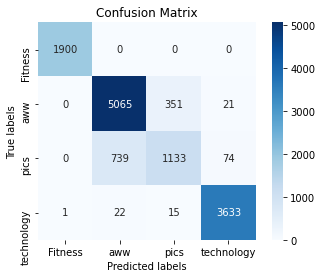

In [0]:
rf_model_3, rf_train_3, rf_test_3, rf_c_report_3 = build_model_1(RandomForestClassifier(n_jobs = -1), 
                                                                 {"n_estimators": [100, 150]}, 
                                                                 X_train_3, X_test_3, y_train_3, y_test_3)

In [0]:
tfidf_precision = [lr_c_report_3['macro avg']['precision'], 
                   #knn_c_report_3['macro avg']['precision'],  
                   rf_c_report_3['macro avg']['precision']]
tfidf_acc = [lr_test_acc_3, rf_test_3] #knn_test_acc_3, rf_test_3]
tfidf_f1 = [lr_c_report_3['macro avg']['f1-score'], 
            #knn_c_report_3['macro avg']['f1-score'],  
            rf_c_report_3['macro avg']['f1-score']]

In [0]:
count_precision = [lr_c_report_1['macro avg']['precision'], 
                   #knn_c_report_1['macro avg']['precision'],  
                   rf_c_report_1['macro avg']['precision']]
count_acc = [lr_test_acc_1, rf_test_1]#knn_test_1, rf_test_1]
count_f1 = [lr_c_report_1['macro avg']['f1-score'], 
            #knn_c_report_1['macro avg']['f1-score'],  
            rf_c_report_1['macro avg']['f1-score']]

In [0]:
Score_df_3 = pd.DataFrame({'tfidf_precision': tfidf_precision, 'count_precision':count_precision,
                           'tfidf_acc': tfidf_acc, 'count_acc':count_acc,
                           'tfidf_f1':tfidf_f1, 'count_f1':count_f1}, index = ['Logistic Regression', 'Random Forest'])
Score_df_3.head()

,tfidf_precision,count_precision,tfidf_acc,count_acc,tfidf_f1,count_f1
Logistic Regression,0.858153,0.858217,0.847537,0.864521,0.794110,0.835101
Random Forest,0.899802,0.900893,0.905589,0.907210,0.884733,0.887811


Comparing bag-of-words model and tf-idf model, both of them are used to deal with text features and applied the processed text into the model. We can see from Score_df_3, **bag-of-words model** performs better for most matrix. In my opinion, it is becasue most of the posts are independent, we don't need to consider the document frequency.

By the way, based on the classification reports for each algorithm, we can see that **all of the algorithms are bad estimator when predicting subreddit r/pics**. I guess one reason is that the r/aww is also a subreddit about pictures. From the [webpage](https://www.reddit.com/r/aww/), we can see the description of the subreddit is *'A subreddit for cute and cuddly pictures'*. It is very easy for the estimator to mix up these two subreddits, but why the prediction accuracy is higher for r/aww? That's the second reason: **There are twice more posts in r/aww than in r/pics.**

## Part 4: Sentiment Analysis

In [0]:
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,url_encode,text
1,abcuz2,mikebeingfrank,2019-01-01,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg,b,In an average wage worker had to clock hours...
5,abcv7e,RyanGwood12,2019-01-01,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg,b,Heres a reminder to grab one of these for a be...
13,abcvty,popedotninja,2019-01-01,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg,b,My best photo of
14,abcvv8,[deleted],2019-01-01,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg,b,Have a happy you sexy people
20,abcwfb,wearestardust24,2019-01-01,pics,Adult male polar bear. Photo: Paul Nicklen,4,69,,https://i.redd.it/jzyd4nhodp721.jpg,b,Adult male polar bear Photo Paul Nicklen


In [0]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("vader_lexicon")

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### (a) Use Vader to compute for each post the sentiment of title field.

In [0]:
# Use vader to evaluated sentiment of title
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
titles = data['title'].values
titleDF = evalSentences(titles, to_df=True, columns=['titleCol','vader'])
titleDF.head()

100%|██████████| 39254/39254 [00:05<00:00, 7237.30it/s]


,titleCol,vader
0,"In 1964, an average wage worker had to clock 8...",0.4404
1,Here’s a reminder to grab one of these for a b...,0.0000
2,My best photo of 2018!,0.6696
3,Have a happy 2019 you sexy people!,0.8122
4,Adult male polar bear. Photo: Paul Nicklen,0.0000


In [0]:
df_sentiment = pd.concat([data.reset_index(drop=True), titleDF.vader], axis=1)
df_sentiment.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,url_encode,text,vader
0,abcuz2,mikebeingfrank,2019-01-01,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg,b,In an average wage worker had to clock hours...,0.4404
1,abcv7e,RyanGwood12,2019-01-01,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg,b,Heres a reminder to grab one of these for a be...,0.0000
2,abcvty,popedotninja,2019-01-01,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg,b,My best photo of,0.6696
3,abcvv8,[deleted],2019-01-01,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg,b,Have a happy you sexy people,0.8122
4,abcwfb,wearestardust24,2019-01-01,pics,Adult male polar bear. Photo: Paul Nicklen,4,69,,https://i.redd.it/jzyd4nhodp721.jpg,b,Adult male polar bear Photo Paul Nicklen,0.0000


In [0]:
df_sentiment.isnull().sum().any()

False

### (b) Analyze the distribution of sentiments for each of your 4 subreddit. What can you learn from the results? 

In [0]:
vader_pics = df_sentiment.loc[df_sentiment.subreddit == 'pics']['vader']
vader_Fitness = df_sentiment.loc[df_sentiment.subreddit == 'Fitness']['vader']
vader_aww = df_sentiment.loc[df_sentiment.subreddit == 'aww']['vader']
vader_technology = df_sentiment.loc[df_sentiment.subreddit == 'technology']['vader']

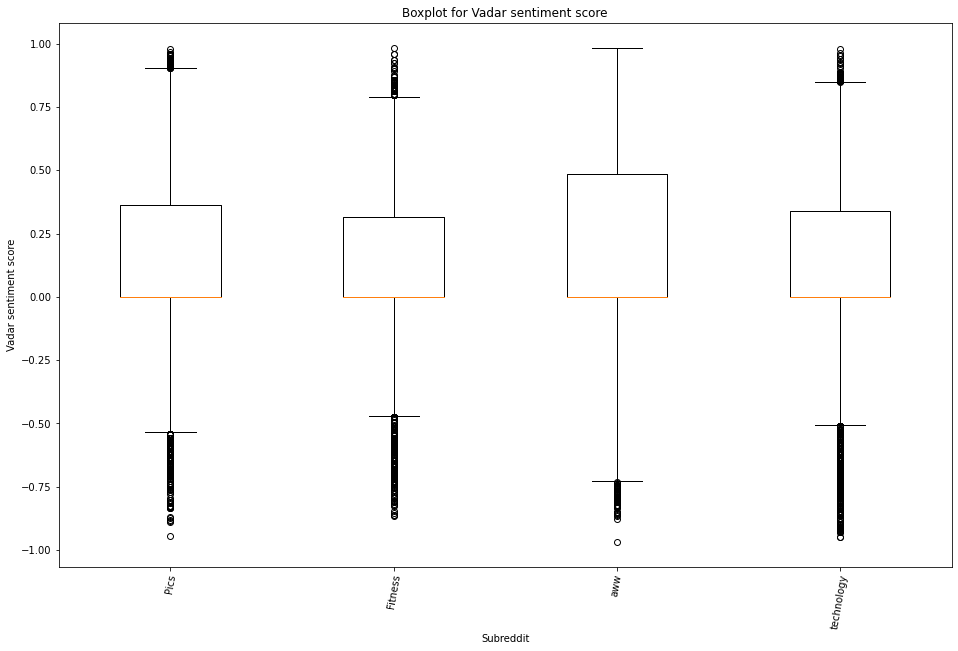

In [0]:
data_Vd = [vader_pics, vader_Fitness, vader_aww, vader_technology]
# multiple box plots on one figure
plt.figure(figsize=(16,10))
plt.boxplot(data_Vd)
plt.title('Boxplot for Vadar sentiment score')
plt.xticks([1,2,3,4],['Pics', 'Fitness', 'aww', 'technology'], rotation = 80)
plt.xlabel('Subreddit')
plt.ylabel('Vadar sentiment score')
plt.show()

From the Boxplot for vader sentiment scores, we can see that for each subreddit, **the median and the first quartile are both 0**, which means that many posts are just **neutral** (the positive and negative words in the title of each posts just cancel each other out, or the text is just very neutral). Since the first quartile and the median coincide, the positive posts based on vader score are more than the negative posts. Maybe because people tend to show off in social media and hide something bad.

### (c) Define a threshold for posts that are clearly positive and clearly negative according to Vader (e.g., > 0.75 and <-0.75, but this should be informed based on the distribution of values in your data) and assign a label for each post accordingly, while removing posts that are not clearly negative or positive.

In [0]:
(vader_pics.quantile([0.75])+vader_Fitness.quantile([0.75])+vader_aww.quantile([0.75])+vader_technology.quantile(0.75))/4

0.75    0.375919
Name: vader, dtype: float64

From the bosplot, we can use **the average first quantile** and the **third quantile** to define that the posts with vader score <0 are negative posts; the posts with vader score > 0.38 are positive posts.

In [0]:
df_sentiment['sentiment'] = ''
for i, row in df_sentiment.iterrows():
    if row['vader'] > 0.38:
        df_sentiment.at[i,'sentiment'] = 'positive'
    if row['vader'] < 0:
        df_sentiment.at[i,'sentiment'] = 'negative'

In [0]:
# Extract the neutral posts and leave only positive and negative posts.
df_sentiment = df_sentiment.loc[df_sentiment['sentiment'] != '']
df_sentiment.shape

(16810, 13)

### (d) For each of the four subreddits, compute the top words that tend to occur in (i) positive titles (ii) negative titles, based on the threshold for positive/negative in (c).
#### a. Analyze the results: do you notice any subreddit-specific patterns?
#### b. Explain the method/metric you used in your analysis and justify why it was appropriate here.

In [0]:
def dataFrameTransformation(df1, df2, k=500):
    titles = df2['titleCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for title in titles:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', title) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqtitle = []
    for i in range(len(titles)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',titles[i])])
        topkintitle = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqtitle.append(topkintitle)
        
        
    #Prepare freqReviewDf
    freqtitleDf = pd.DataFrame(freqtitle)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqtitleDf.columns = dfName
    finaltitleDf = df2.join(freqtitleDf)
    finaldf = df1[['id', 'author', 'created_utc', 'subreddit', 'num_comments', 'score', 'selftext', 'url', 'sentiment']].join(finaltitleDf)
    return topk, finaldf

In [0]:
top_k, finaldf =  dataFrameTransformation(df_sentiment, titleDF, k=500)

In [0]:
def getTopK(df, k, reddit, label_value, label_column='sentiment', operation=operator.eq, value_column='titleCol'):
    stop = set(stopwords.words('english'))

    counter = Counter()
    df = df[df['subreddit'] == reddit]
    for title in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word in re.findall(r'\w+', title) if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

### For subreddit 'Pics'

In [0]:
topkPos = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'pics', label_value='positive')
topkPos

[('best', 131),
 ('photo', 116),
 ('friend', 100),
 ('took', 96),
 ('new', 95),
 ('like', 90),
 ('one', 89),
 ('picture', 86),
 ('year', 81),
 ('love', 77),
 ('2018', 72),
 ('beautiful', 72),
 ('happy', 71),
 ('good', 67),
 ('day', 63),
 ('today', 61),
 ('years', 60),
 ('favorite', 58),
 ('pic', 53),
 ('great', 51),
 ('got', 48),
 ('made', 43),
 ('get', 39),
 ('little', 39),
 ('thought', 38),
 ('first', 37),
 ('last', 36),
 ('amazing', 36),
 ('really', 34),
 ('friends', 33),
 ('shot', 32),
 ('found', 31),
 ('reddit', 30),
 ('old', 30),
 ('guy', 30),
 ('taken', 29),
 ('would', 28),
 ('pretty', 28),
 ('think', 28),
 ('wife', 28),
 ('painted', 28),
 ('world', 28),
 ('night', 28),
 ('hope', 27),
 ('ever', 27),
 ('know', 27),
 ('look', 26),
 ('share', 25),
 ('house', 25),
 ('proud', 25)]

In [0]:
topkNeg = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'pics', label_value='negative')
topkNeg

[('one', 44),
 ('photo', 32),
 ('today', 31),
 ('year', 29),
 ('picture', 29),
 ('like', 26),
 ('fire', 26),
 ('years', 26),
 ('got', 25),
 ('new', 22),
 ('bad', 20),
 ('last', 20),
 ('made', 19),
 ('old', 19),
 ('day', 19),
 ('cat', 18),
 ('took', 18),
 ('little', 18),
 ('first', 17),
 ('died', 17),
 ('time', 16),
 ('work', 16),
 ('car', 16),
 ('lost', 16),
 ('shit', 15),
 ('found', 15),
 ('back', 15),
 ('fuck', 14),
 ('get', 14),
 ('ago', 14),
 ('looking', 14),
 ('weird', 14),
 ('man', 14),
 ('guy', 14),
 ('make', 13),
 ('wife', 13),
 ('pic', 13),
 ('taken', 13),
 ('see', 13),
 ('never', 13),
 ('dead', 12),
 ('look', 12),
 ('people', 12),
 ('dog', 12),
 ('stop', 12),
 ('school', 12),
 ('abandoned', 12),
 ('two', 12),
 ('wrong', 12),
 ('accidentally', 12)]

As for the top 50 words in positive titles for r/pics, there are some words like 'best', 'great', 'good'; for the top 50 words in negative titles, there are words like 'bad', 'old', 'never', etc, which means that the distinction between positive titles and negative titles are clear.<br>
Also in both positive titles and negative titles, there exist words like 'photo', 'picture', 'took', which means there are subreddit-specific patterns, we can easily say the words are from some subreddits about pictures or photo.

### For subreddit 'Fitness'

In [0]:
topkPos_fit = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'Fitness', label_value='positive')
topkPos_fit

[('help', 263),
 ('best', 171),
 ('workout', 129),
 ('good', 125),
 ('weight', 109),
 ('fitness', 97),
 ('need', 96),
 ('muscle', 92),
 ('gain', 86),
 ('routine', 75),
 ('strength', 70),
 ('gym', 68),
 ('get', 61),
 ('fat', 54),
 ('progress', 54),
 ('training', 47),
 ('body', 47),
 ('tips', 45),
 ('like', 44),
 ('would', 44),
 ('day', 43),
 ('advice', 41),
 ('healthy', 40),
 ('improve', 40),
 ('exercises', 40),
 ('better', 38),
 ('way', 37),
 ('looking', 36),
 ('diet', 35),
 ('program', 35),
 ('year', 32),
 ('gaining', 32),
 ('getting', 31),
 ('want', 31),
 ('time', 30),
 ('anyone', 30),
 ('please', 29),
 ('work', 29),
 ('fit', 29),
 ('cardio', 28),
 ('free', 28),
 ('protein', 27),
 ('back', 27),
 ('plan', 27),
 ('skinny', 27),
 ('lifting', 25),
 ('workouts', 25),
 ('running', 23),
 ('guys', 23),
 ('app', 23)]

In [0]:
topkNeg_fit = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'Fitness', label_value='negative')
topkNeg_fit

[('weight', 190),
 ('pain', 106),
 ('fat', 95),
 ('lose', 93),
 ('cut', 79),
 ('back', 68),
 ('workout', 62),
 ('muscle', 61),
 ('loss', 60),
 ('gym', 57),
 ('losing', 52),
 ('advice', 52),
 ('get', 50),
 ('bad', 47),
 ('cutting', 44),
 ('body', 43),
 ('injury', 42),
 ('lower', 39),
 ('day', 37),
 ('wrong', 36),
 ('shoulder', 35),
 ('want', 34),
 ('working', 34),
 ('low', 33),
 ('start', 33),
 ('need', 33),
 ('exercises', 32),
 ('help', 31),
 ('time', 31),
 ('bulk', 29),
 ('sore', 29),
 ('anyone', 29),
 ('lifting', 29),
 ('exercise', 29),
 ('stop', 28),
 ('question', 27),
 ('fitness', 26),
 ('looking', 26),
 ('getting', 26),
 ('calories', 26),
 ('knee', 25),
 ('routine', 24),
 ('feel', 24),
 ('bench', 24),
 ('chest', 24),
 ('protein', 24),
 ('trying', 23),
 ('work', 22),
 ('going', 22),
 ('year', 22)]

In r/Fitness, there are many positive words in positive titles like 'good', 'best', 'improve', 'healthy'; while there are negative words in negative titles like 'pain', 'wrong', 'bad', which means the difference between positive titles and negative titles is obvious. This time, there are many words about different parts of body, and both nagative titles and positive titles have words like 'weight', 'fitness', 'calories', 'loss', which are fitness-specific words.

### For subreddit 'aww'

In [0]:
topkPos_fit_aww = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'aww', label_value='positive')
topkPos_fit_aww

[('cat', 557),
 ('dog', 469),
 ('cute', 447),
 ('best', 419),
 ('good', 410),
 ('love', 393),
 ('little', 350),
 ('happy', 334),
 ('old', 328),
 ('friend', 317),
 ('boy', 311),
 ('loves', 291),
 ('meet', 290),
 ('new', 276),
 ('like', 275),
 ('today', 240),
 ('girl', 219),
 ('day', 218),
 ('one', 208),
 ('ever', 194),
 ('years', 191),
 ('year', 184),
 ('got', 183),
 ('first', 183),
 ('likes', 179),
 ('home', 165),
 ('adorable', 164),
 ('beautiful', 164),
 ('reddit', 153),
 ('puppy', 150),
 ('sweet', 142),
 ('friends', 141),
 ('baby', 141),
 ('still', 135),
 ('get', 135),
 ('think', 133),
 ('favorite', 126),
 ('adopted', 123),
 ('birthday', 119),
 ('time', 119),
 ('kitten', 117),
 ('name', 115),
 ('picture', 110),
 ('rescue', 108),
 ('rescued', 108),
 ('found', 105),
 ('much', 103),
 ('cutest', 100),
 ('guy', 99),
 ('kitty', 97)]

In [0]:
topkNeg_fit_aww = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'aww', label_value='negative')
topkNeg_fit_aww

[('cat', 233),
 ('dog', 172),
 ('little', 114),
 ('day', 73),
 ('get', 70),
 ('old', 65),
 ('one', 65),
 ('got', 65),
 ('bad', 57),
 ('like', 54),
 ('puppy', 52),
 ('new', 50),
 ('first', 49),
 ('girl', 49),
 ('time', 48),
 ('meet', 48),
 ('boy', 48),
 ('home', 47),
 ('think', 47),
 ('baby', 45),
 ('found', 40),
 ('lost', 39),
 ('kitten', 39),
 ('hard', 39),
 ('years', 38),
 ('today', 37),
 ('guy', 36),
 ('work', 36),
 ('year', 35),
 ('back', 35),
 ('cats', 33),
 ('want', 33),
 ('kitty', 32),
 ('blind', 31),
 ('bed', 31),
 ('tired', 30),
 ('scared', 29),
 ('face', 29),
 ('leave', 29),
 ('never', 29),
 ('morning', 29),
 ('look', 29),
 ('mom', 28),
 ('always', 28),
 ('poor', 28),
 ('stop', 28),
 ('ever', 27),
 ('sick', 27),
 ('life', 26),
 ('say', 26)]

Since the subreddit r/aww is about cute and cuddly pictures (especially puppies, bunnies and babies), there are many words about puppies like 'cat', 'dog' or about babies, like 'boy', 'girl' (also boy or girl also used for puppies), 'mom'. In Western society, puppies are treated like babies, they are very similar. From the words, I can point out these words are very subreddit-specific. <br>
In the top words for positive titles, there are 'cute', 'best', etc; in the nagative title words, there are not so much negative words but some words like 'tired' or 'lost', but not bad words used to describe the puppies or babies directly.

### For Subreddit 'technology'

In [0]:
topkPos_fit_tech = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'technology', label_value='positive')
topkPos_fit_tech

[('support', 342),
 ('best', 329),
 ('free', 221),
 ('help', 217),
 ('number', 189),
 ('2019', 168),
 ('smart', 122),
 ('new', 122),
 ('market', 117),
 ('tech', 115),
 ('usa', 108),
 ('877', 108),
 ('router', 103),
 ('app', 96),
 ('amp', 93),
 ('netgear', 88),
 ('get', 86),
 ('google', 83),
 ('technology', 83),
 ('download', 80),
 ('customer', 80),
 ('facebook', 79),
 ('growth', 73),
 ('printer', 73),
 ('phone', 71),
 ('company', 67),
 ('technical', 66),
 ('4999', 63),
 ('service', 62),
 ('269', 62),
 ('security', 62),
 ('better', 62),
 ('top', 61),
 ('apple', 60),
 ('software', 60),
 ('android', 59),
 ('mobile', 57),
 ('data', 57),
 ('business', 57),
 ('intelligence', 57),
 ('need', 56),
 ('2018', 54),
 ('development', 54),
 ('microsoft', 54),
 ('good', 53),
 ('online', 51),
 ('web', 51),
 ('please', 49),
 ('digital', 48),
 ('services', 48)]

In [0]:
topkNeg_fit_tech = getTopK(df=finaldf[['titleCol', 'subreddit', 'sentiment']], k=50, reddit = 'technology', label_value='negative')
topkNeg_fit_tech

[('facebook', 134),
 ('data', 113),
 ('apple', 112),
 ('die', 105),
 ('google', 100),
 ('huawei', 96),
 ('new', 80),
 ('mit', 77),
 ('says', 75),
 ('euro', 73),
 ('tech', 70),
 ('china', 67),
 ('tarife', 67),
 ('für', 65),
 ('gibt', 62),
 ('fake', 59),
 ('could', 56),
 ('privacy', 55),
 ('iphone', 54),
 ('2019', 49),
 ('news', 49),
 ('net', 48),
 ('amp', 48),
 ('problem', 45),
 ('stop', 44),
 ('smartphone', 43),
 ('technology', 43),
 ('und', 42),
 ('error', 41),
 ('fix', 41),
 ('internet', 41),
 ('neutrality', 41),
 ('phone', 40),
 ('amazon', 40),
 ('government', 39),
 ('app', 39),
 ('people', 39),
 ('court', 39),
 ('shutdown', 36),
 ('microsoft', 35),
 ('million', 34),
 ('der', 34),
 ('users', 34),
 ('company', 34),
 ('flat', 34),
 ('bei', 34),
 ('big', 32),
 ('may', 32),
 ('one', 32),
 ('online', 31)]

From these two words sets, there are words like 'smart', 'tech', 'phone', 'app', etc, which shows that these words are from r/technology clearly.<br>
There are positive agjectives like 'good', 'new', 'free' in the top words for positive titles and 'fake', 'error' 'shutdown' in the top words for negative titles. The sentiments between positive titles and negative titles are distinct.

In question (c), I labeled the positive posts and negative posts by the vader score above the average third quantile or below the average first quantile. Then select the top 500 frequency words from all the title texts and tokenize each title if the tokened words in the title also in the top 500 frequency words. Later for each title, I tokenized the words based on the positive and negative sentiment and returned the top 50 frequency words for positive titles and negative titles for each subreddit. Based on the results above, in each subreddit, the returned words are very subreddit-specific and the positive words and negative words are very distinct. 

## Reference

1. [Reddit Post Classification](https://towardsdatascience.com/reddit-post-classification-b70258d6affe) <br>
2. [Modern Text Mining with Python, Part 2 of 5: Data Exploration with Pandas](https://medium.com/@datanizing/modern-text-mining-with-python-part-2-of-5-data-exploration-with-pandas-ee3456cf6a4) <br>
3. [Text categorization: combining different kind of features](https://datascience.stackexchange.com/a/9642) <br>
4. [Dealing with Multiclass Data](https://towardsdatascience.com/dealing-with-multiclass-data-78a1a27c5dcc) <br>
5. [Overview of Classification Methods in Python with Scikit-Learn](https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/) <br>
6. [a general measure of data-set imbalance](https://stats.stackexchange.com/a/245828) <br>
7. [Text categorization: combining different kind of features](https://datascience.stackexchange.com/questions/987/text-categorization-combining-different-kind-of-features/9642#9642)